# Classification of Waste Wood

# Import of packages and functions

Packages and functions used for this project are called:

In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
from scipy.signal import savgol_filter, general_gaussian
import sklearn
from sklearn.model_selection import train_test_split, GroupShuffleSplit, StratifiedGroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay
import math
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, Conv2D, BatchNormalization, Flatten, MaxPooling1D
from keras import optimizers
from keras.regularizers import L2
from keras.callbacks import EarlyStopping
import shap

# The waste wood data set

The data set is loaded and prepared for modelling. Throughout working with the data set, some replicates have been found to be errenous. These have been removed as outliers.

In [ ]:
drive.mount('/content/drive')
ww_df = pd.read_csv('/content/drive/MyDrive/Machine Learning and Molecules/Hackaton.csv', delimiter=';')
ww_df.drop(ww_df.columns[len(ww_df.columns)-1], axis=1, inplace=True)
ww_df.drop(ww_df.tail(1).index,inplace=True)
ww_df.columns = ww_df.columns.str.strip()
ww_df[['Scan', 'Replicate', 'Sample', 'Type']] = ww_df[['Scan', 'Replicate', 'Sample', 'Type']].astype(float)
ww_df = ww_df[(ww_df['Sample'] != 82.0) | (~ww_df['Replicate'].isin([2, 3]))]
ww_df = ww_df[(ww_df['Sample'] != 84.0) | (ww_df['Replicate'] != 1)]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-2-57c1ee208821>:2: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  ww_df = pd.read_csv('/content/drive/MyDrive/Machine Learning and Molecules/Hackaton.csv', delimiter=';')


Given that the classification task for this project is multi-class, three columns of one-hot encoded class membership is introduced.

In [ ]:
def binary_class_membership(row):
    treated_wood = 1 if row['Type'] == 1 else 0
    virgin_wood = 1 if row['Type'] == 2 else 0
    disposal_wood = 1 if row['Type'] == 3 else 0
    return pd.Series({'Treated Wood': treated_wood, 'Virgin Wood': virgin_wood, 'Disposal Wood': disposal_wood})
class_columns = ww_df.apply(binary_class_membership, axis=1)
ww_df = pd.concat([class_columns, ww_df], axis=1)

Furthermore, to gain an overview of the distribution of the assigned classes, the count of each class is plotted:

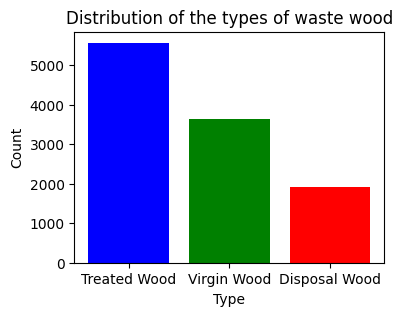

In [ ]:
color_mapping = {
    'Treated Wood': 'blue',
    'Virgin Wood': 'green',
    'Disposal Wood': 'red'
}
y = ww_df[['Treated Wood', 'Virgin Wood', 'Disposal Wood']]
counts = y.sum()
colors = [color_mapping[type_] for type_ in counts.index]
plt.figure(figsize=(4, 3))
plt.bar(counts.index, counts.values, color=colors)
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Distribution of the types of waste wood')
plt.show()

The most abundant type of waste wood is treated wood, which will be utilized when constructing the "null model".

# Raw data inspection

The raw NIR spectra are inspected. The spectra are colored by their assigned class.

In [ ]:
def plot_spectra(data):
  '''Plotting of the individual NIR spectra colored by the type of waste wood'''
  data_long = pd.melt(data, id_vars=['Scan','Replicate','Sample','Type'], value_vars=data.columns[7:])
  data_long['variable'] = data_long['variable'].astype(int)
  data_long['Type'] = data_long['Type'].replace({1: 'Treated Wood', 2: 'Virgin Wood', 3: 'Disposal Wood'})
  color_mapping = {
      'Treated Wood': 'blue',
      'Virgin Wood': 'green',
      'Disposal Wood': 'red'
  }
  spectra = data_long.groupby(['Scan', 'Replicate', 'Sample'])
  for name, spectrum in spectra:
      plt.plot(spectrum['variable'], spectrum['value'], linewidth=0.5, color=color_mapping[spectrum['Type'].iloc[0]])

  for utype, color in color_mapping.items():
      plt.plot([], [], label=utype, color=color)

  plt.legend(title='Type')
  plt.xlabel('Wavelength (nm)')
  plt.ylabel('Absorbance')
  plt.title('NIR Spectra')
  return plt.show()

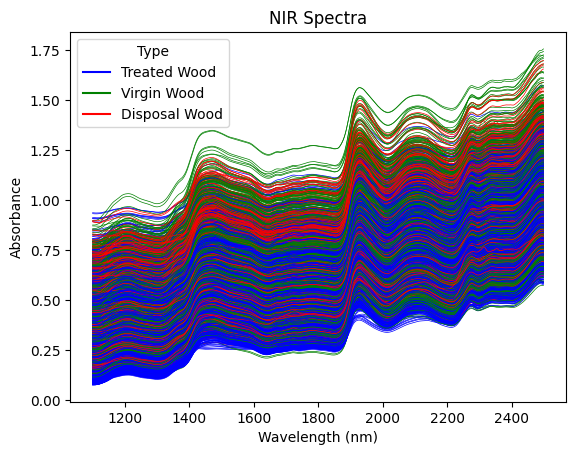

In [ ]:
plot_spectra(ww_df)

Inspection of the raw data reveals a common artefact of NIRS: scattering observed as a baseline off-sets and slope of the spectra. To alleviate this issue, pre-processing will be applied to the spectra prior to building of the model.


# Pre-processing

Functions for two common methods of row normalization within NIRS are defined: Standard Normal Variate (SNV) and Multiplicative Scatter Correction (MSC). SNV is accomplished by subtracting the row mean, and then scaling by dividing by the standard deviation. MSC entails correcting each spectra with the slope and offset found using a reference spectrum. Furthermore, a function perfoming Savitzky-Golay (SG) filters is defined. This function requires the input of filter-width and polynomial order for spectral smoothing, and the deriative to be applied. Lastly, a function executing mean centering (MC), a column-wise transformation, is also defined. MC is performed by subtracting the average of each variable from every element of its column.

Different combinations of pre processing are tried untill satisfactory scatter correction is achieved by visual inspection, and the best results with the model are achieved. The sequential order of pre-processing is always scatter-correction followed by MC.

In [ ]:
def snv(data):
  '''Perform Standard Normal Variate'''
  wavelengths = data.columns[7:]
  spectra = data.iloc[:, 7:]
  df = np.zeros_like(spectra)
  for i in range(spectra.shape[0]):
    df[i, :] = (spectra.iloc[i, :] - np.mean(spectra.iloc[i, :])) / np.std(spectra.iloc[i, :])
  pp_df = pd.DataFrame(data = df,
                       columns = wavelengths)
  return pd.concat([data.iloc[:, :7].reset_index(drop=True), pp_df.reset_index(drop=True)], axis=1)

In [ ]:
def msc_median(data):
  '''Perfrom Multiplicative Scatter Correction'''
  wavelengths = data.columns[7:]
  spectra = data.iloc[:, 7:].values
  ref = np.median(spectra, axis=0)
  df = np.zeros_like(spectra)
  for i in range(spectra.shape[0]):
      fit = np.polyfit(ref, spectra[i,:], 1, full=True)
      df[i,:] = ((spectra[i,:]) - fit[0][1]) / fit[0][0]
  pp_df = pd.DataFrame(data = df,
                       columns = wavelengths)
  return pd.concat([data.iloc[:, :7].reset_index(drop=True), pp_df.reset_index(drop=True)], axis=1)

In [ ]:
def msc_mean(data):
  '''Perfrom Multiplicative Scatter Correction'''
  wavelengths = data.columns[7:]
  spectra = data.iloc[:, 7:].values
  ref = np.mean(spectra, axis=0)
  df = np.zeros_like(spectra)
  for i in range(spectra.shape[0]):
      fit = np.polyfit(ref, spectra[i,:], 1, full=True)
      df[i,:] = ((spectra[i,:]) - fit[0][1]) / fit[0][0]
  pp_df = pd.DataFrame(data = df,
                       columns = wavelengths)
  return pd.concat([data.iloc[:, :7].reset_index(drop=True), pp_df.reset_index(drop=True)], axis=1)

In [ ]:
def sg(data, w, p, d):
  '''Perform Savitzky-Golay'''
  wavelengths = data.columns[7:]
  spectra = data.iloc[:, 7:]
  df = savgol_filter(spectra, w, polyorder=p, deriv=d)
  pp_df = pd.DataFrame(data = df,
                       columns = wavelengths)
  return pd.concat([data.iloc[:, :7].reset_index(drop=True), pp_df.reset_index(drop=True)], axis=1)

In [ ]:
def mc(data):
  '''Perfrom Mean Centering'''
  wavelengths = data.columns[7:]
  spectra = data.iloc[:, 7:]
  df = np.zeros_like(spectra)
  for i in range(df.shape[1]):
      df[:, i] = spectra.iloc[:, i] - np.mean(spectra.iloc[:, i])
  pp_df = pd.DataFrame(data = df,
                      columns = wavelengths)
  return pd.concat([data.iloc[:, :7].reset_index(drop=True), pp_df.reset_index(drop=True)], axis=1)

 The data set is pre-processed and the row order is randomized to ensure generalization of the final model. The ideal method of pre-processing was found to be MSC median and MSC mean followed by MC.

In [ ]:
ww_df_pp = mc(msc_mean(msc_median(ww_df)))
ww_df_pp = ww_df_pp.sample(frac=1, random_state=42)

In a similar manner to the raw data, the pre-processed data is inspected:

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


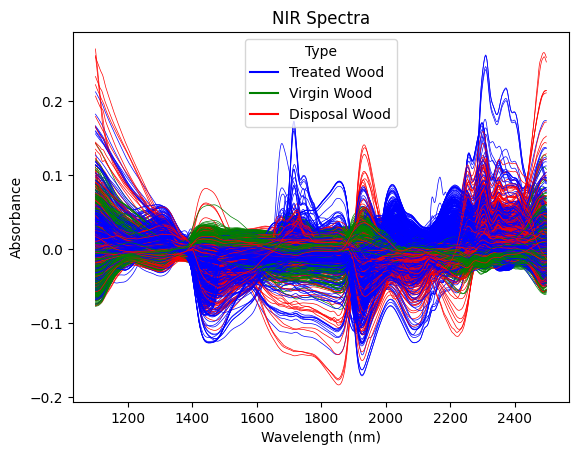

In [ ]:
plot_spectra(ww_df_pp)

Following the applied pre-processing, spectral variation between the types of waste wood is much more apparent. Bulding a model using the raw data resulted in a model with no predictive abilities identical to the null model. Similarly, this was observed for other methods of pre-processing such as the SG filter.



# Introducing the training, validation set, and test set

The chosen distribution for the training set, validation set, and test set are 80%, 10%, and 10%. To ensure fair estimation of predictive abilities of the model, it is ensured that all spectra associated with a given sample are consistently placed in the same set (i.e., all replicates and scans)

In [ ]:
train_index, test_index = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state=None).split(ww_df_pp, groups=ww_df_pp['Sample']))
val_index, test_index = next(GroupShuffleSplit(test_size=.50, n_splits=2, random_state=None).split(ww_df_pp.iloc[test_index], groups=ww_df_pp.iloc[test_index][['Sample']]))
X_train = ww_df_pp.iloc[train_index].iloc[:, 7:]
y_train = ww_df_pp.iloc[train_index][['Treated Wood', 'Virgin Wood', 'Disposal Wood']]
X_val = ww_df_pp.iloc[val_index].iloc[:, 7:]
y_val = ww_df_pp.iloc[val_index][['Treated Wood', 'Virgin Wood', 'Disposal Wood']]
X_test = ww_df_pp.iloc[test_index].iloc[:, 7:]
y_test = ww_df_pp.iloc[test_index][['Treated Wood', 'Virgin Wood', 'Disposal Wood']]

The distribution of classes in the training  set, validation set, and test set are investigated:

In [ ]:
counts_train = pd.Series(y_train.sum(), name='Training')
counts_val = pd.Series(y_val.sum(), name='Validation')
counts_test = pd.Series(y_test.sum(), name='Test')
counts_distribution = pd.concat([counts_train, counts_val, counts_test], axis=1)
counts_distribution = counts_distribution.div(counts_distribution.sum(axis=0), axis=1).round(2)
display(counts_distribution)

,Training,Validation,Test
Treated Wood,0.50,0.50,0.50
Virgin Wood,0.34,0.33,0.32
Disposal Wood,0.16,0.17,0.18


The distribution of waste wood types appears fairly consistent throughout all iterations.

# Building the classification model

The classification model is built using two one dimensional convolutional layers, one pooling layer, and a flattening layer. A fully connected layer between the convolutional layers and the output layer was not included as it worsened the accuracy rate for the test set.

In [ ]:
ww_model = Sequential([
    Conv1D(filters=31, kernel_size=32, padding='same', activation='relu', input_shape=(700,1)),
    Conv1D(filters=41, kernel_size=16, padding='same', activation='relu'),
    MaxPooling1D(pool_size=1, strides=1),
    Flatten(),
    Dropout(0.1),
    BatchNormalization(),
    Dense(3, activation='softmax', kernel_regularizer=L2(0.0001))
])

ww_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.000001),
    loss='categorical_crossentropy')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

ww_training = ww_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/100
276/276 [==============================] - 47s 167ms/step - loss: 0.6062 - val_loss: 0.9466
Epoch 2/100
276/276 [==============================] - 52s 190ms/step - loss: 0.4988 - val_loss: 0.5948
Epoch 3/100
276/276 [==============================] - 44s 159ms/step - loss: 0.4655 - val_loss: 0.4825
Epoch 4/100
276/276 [==============================] - 42s 153ms/step - loss: 0.4391 - val_loss: 0.3866
Epoch 5/100
276/276 [==============================] - 40s 146ms/step - loss: 0.3994 - val_loss: 0.4256
Epoch 6/100
276/276 [==============================] - 43s 156ms/step - loss: 0.3762 - val_loss: 0.3603
Epoch 7/100
276/276 [==============================] - 41s 149ms/step - loss: 0.3658 - val_loss: 0.3408
Epoch 8/100
276/276 [==============================] - 40s 145ms/step - loss: 0.3347 - val_loss: 0.4404
Epoch 9/100
276/276 [==============================] - 38s 137ms/step - loss: 0.3208 - val_loss: 0.3788
Epoch 10/100
276/276 [==============================] - 40s 146m

The training and validation loss (categorical cross-entropy) is plotted. Early stopping has been implemented based on the loss functions, restoring the best weights.

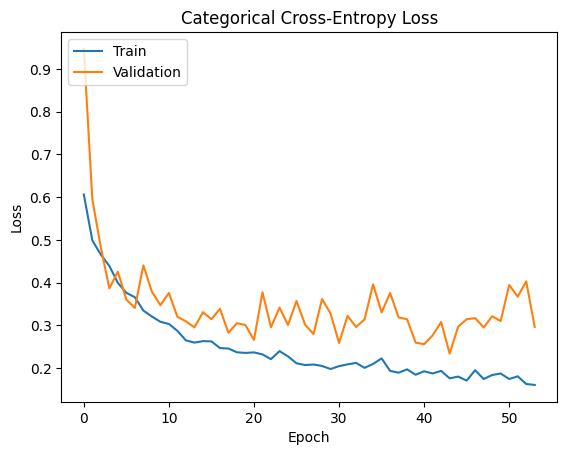

In [ ]:
plt.plot(ww_training.history['loss'])
plt.plot(ww_training.history['val_loss'])
plt.title('Categorical Cross-Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The validation loss is observed to oscillate. Since this issue is not fully alleviated either by decreasing the learning rate or increasing the drop out rate, the oscillation could potentially be imporved by increasing the number of data points in the validation set.

# The confusion matrix

Instead of using a threshold-based approach for class predictions, the highest prediction is assigned to that class ensuring that all spectra in the test set are assigned to a class. This is the "most probable" approach.

In [ ]:
ww_class_predicted = np.eye(ww_model.predict(X_test).shape[1])[ww_model.predict(X_test).argmax(axis=1)]

36/36 [==============================] - 1s 28ms/step


A function to is defined to create the confusion matrix:

In [ ]:
def multiclass_confusion_table(actual, predicted):
  actual_indices = np.argmax(np.array(actual), axis=1)
  predicted_indices = np.argmax(np.array(predicted), axis=1)
  mapping = {0: 0, 1: 1, 2: 2}
  actual_vector = np.vectorize(mapping.get)(actual_indices)
  predicted_vector = np.vectorize(mapping.get)(predicted_indices)
  cm = confusion_matrix(actual_vector, predicted_vector)
  cm_df = pd.DataFrame(cm)
  cm_df.columns = ['Predicted: Treated Wood', 'Predicted: Virgin Wood', 'Predicted: Disposal Wood']
  cm_df.index = ['Actual: Treated Wood', 'Actual: Virgin Wood', 'Actual: Disposal Wood']
  return cm_df


In [ ]:
confusion_table = multiclass_confusion_table(y_test, ww_class_predicted)
display(confusion_table)

,Predicted: Treated Wood,Predicted: Virgin Wood,Predicted: Disposal Wood
Actual: Treated Wood,545,15,13
Actual: Virgin Wood,5,351,15
Actual: Disposal Wood,7,15,186


The misclassifications of the model do not appear overly systematic.

In [ ]:
def metrics(actual, predicted):
    '''Calculates accuracy, precision, sensitivity, and specificity for each class'''
    cm = multilabel_confusion_matrix(actual, predicted)
    cm_rs = cm.reshape(-1, 4)

    # Treated wood
    accuracy_tw = round((cm_rs[0, 0] + cm_rs[0, 3]) / cm_rs[0].sum(), 2)
    precision_tw = round(cm_rs[0, 3] / (cm_rs[0, 3] + cm_rs[0, 1]), 2) if (cm_rs[0, 3] + cm_rs[0, 1]) != 0 else 0.0
    sensitivity_tw = round(cm_rs[0, 3] / (cm_rs[0, 3] + cm_rs[0, 2]), 2)
    specificity_tw = round(cm_rs[0, 0] / (cm_rs[0, 0] + cm_rs[0, 1]), 2)

    # Virgin Wood
    accuracy_vw = round((cm_rs[1, 0] + cm_rs[1, 3]) / cm_rs[1].sum(), 2)
    precision_vw = round(cm_rs[1, 3] / (cm_rs[1, 3] + cm_rs[1, 1]), 2) if (cm_rs[1, 3] + cm_rs[1, 1]) != 0 else 0.0
    sensitivity_vw = round(cm_rs[1, 3] / (cm_rs[1, 3] + cm_rs[1, 2]), 2)
    specificity_vw = round(cm_rs[1, 0] / (cm_rs[1, 0] + cm_rs[1, 1]), 2)

    # Disposal Wood
    accuracy_dw = round((cm_rs[2, 0] + cm_rs[2, 3]) / cm_rs[2].sum(), 2)
    precision_dw = round(cm_rs[2, 3] / (cm_rs[2, 3] + cm_rs[2, 1]), 2) if (cm_rs[2, 3] + cm_rs[2, 1]) != 0 else 0.0
    sensitivity_dw = round(cm_rs[2, 3] / (cm_rs[2, 3] + cm_rs[2, 2]), 2)
    specificity_dw = round(cm_rs[2, 0] / (cm_rs[2, 0] + cm_rs[2, 1]), 2)

    metrics = {
        "Accuracy": [accuracy_tw, accuracy_vw, accuracy_dw],
        "Precision": [precision_tw, precision_vw, precision_dw],
        "Sensitivity": [sensitivity_tw, sensitivity_vw, sensitivity_dw],
        "Specificity": [specificity_tw, specificity_vw, specificity_dw]
    }

    metrics_df = pd.DataFrame(metrics, index=["Treated Wood", "Virgin Wood", "Disposal Wood"])
    return metrics_df

In [ ]:
metrics(y_test, ww_class_predicted)

,Accuracy,Precision,Sensitivity,Specificity
Treated Wood,0.95,0.95,0.96,0.95
Virgin Wood,0.94,0.90,0.92,0.95
Disposal Wood,0.95,0.86,0.82,0.97


All metrics are consistenly above 0.9 for all waste wood types except precision and sensitivity for disposal wood. This could be do to disposal wood being the type least represented in the data set.

# Identifying important variables: Shapley values

Variables important to the model are investigated using Shapley values to potentially be able to apply chemical meaning to important wavelengths.

In [ ]:
background_indices = np.random.choice(X_train.index, 100, replace=False)
background = np.array(X_train.loc[background_indices])
test_indices = np.random.choice(X_test.index, 5, replace=False)
test = np.array(X_test.loc[test_indices])
explainer = shap.KernelExplainer(ww_model.predict, background)
shap_values = explainer.shap_values(test)

In [ ]:
waste_wood_type = ['Treated Wood', 'Virgin Wood', 'Disposal Wood']

wavelengths = list(map(int, ww_df_pp.columns[7:]))
shap_df = pd.DataFrame()

x = 1
for number in range(shap_values.shape[0]):
    df = pd.DataFrame(shap_values[number], columns = waste_wood_type)
    df["number"] = x
    df["wavelengths"] = wavelengths
    shap_df = pd.concat([shap_df, df], ignore_index=True)
    x += 1
shap_df_long = pd.melt(shap_df, id_vars=['number', 'wavelengths'], value_vars=['Treated Wood', 'Virgin Wood', 'Disposal Wood'])

The Shapley Values calculated using a background of 100 spectra for five test spectra are plotted as the mean with the standard deviation indicated by a shadow.

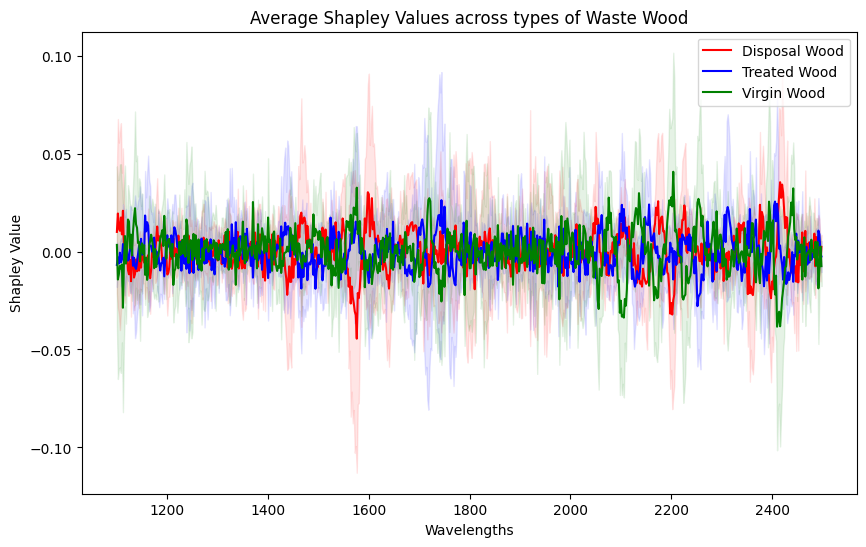

In [ ]:
color_mapping = {
      'Treated Wood': 'blue',
      'Virgin Wood': 'green',
      'Disposal Wood': 'red'
  }

mean_std = shap_df_long.groupby(['variable', 'wavelengths'])['value'].agg(['mean', 'std']).reset_index()

fig, plot = plt.subplots(figsize=(10, 6))

types = mean_std.groupby('variable')
for ww_type, group_data in types:
    x = group_data['wavelengths']
    y = group_data['mean']
    yerr = group_data['std']
    plot.plot(x, y, label=ww_type, linestyle='-', color=color_mapping.get(ww_type, 'black'))
    plot.fill_between(x, y - yerr, y + yerr, color=color_mapping.get(ww_type, 'black'), alpha=0.1)

plot.set_xlabel('Wavelengths')
plot.set_ylabel('Shapley Value')
plot.set_title('Average Shapley Values across types of Waste Wood')

plot.legend()
plt.show()

It is noted that the data was centered around the mean prior to analysis. Therefore, it is inferred that positive Shapley Values would indicate higher absorbance values compared to the mean at a given wavelength and waste wood type and negative Shapley Values would indicate the opposite.

A few wavelengths highlightet as these appear important for the differentation between waste wood types include:
* ~1471 nm: N-H stretch possibly due to glue, which would be expected to be present in disposal wood (positive Shapley Values) but not in Treated Wood and Virgin Wood (negative Shapley Values).
* ~1580 nm: O-H stretch likely due to starch. For disposal wood, the Shapley values are negative but highly variable. This could be due to the large heterogeneity of samples expected in these wood chips due to the surface treatment.
* ~2140 nm: C-H, C=C, and C=O probably due to carbohydrates such as ligning and hemicellulose. Virgin wood has positive Shapley Values, wheras disposal wood has negative.


# The "null model"

The "null model" entails all data entries being predicted as treated wood, which is the type most predominent in the data set. This is a model with no classification abilities.

In [ ]:
ww_null_predicted = np.column_stack((np.ones(y_test.shape[0]), np.zeros((y_test.shape[0], 2))))

In [ ]:
confusion_null_table = multiclass_confusion_table(y_test, ww_null_predicted)
display(confusion_null_table)

,Predicted: Treated Wood,Predicted: Virgin Wood,Predicted: Disposal Wood
Actual: Treated Wood,573,0,0
Actual: Virgin Wood,371,0,0
Actual: Disposal Wood,208,0,0


In [ ]:
metrics(y_test, ww_null_predicted)

,Accuracy,Precision,Sensitivity,Specificity
Treated Wood,0.50,0.5,1.0,0.0
Virgin Wood,0.68,0.0,0.0,1.0
Disposal Wood,0.82,0.0,0.0,1.0


For the "null model", accuracy reflects the distribution of waste wood types. As half of the spectra belong to treated wood, half of the predictions are expected to be true. As anticipated, accuracy is higher for virgin wood and disposal wood as smaller fractions of spectra belong to these. A spectra not belonging to treated wood compared to virgin woood or disposal wood is therefore more probable.

Precision, sensitivity and specificity all indicate the lack of predictive abilities for the "null model". For treated wood, precision is identical to accuracy, whereas a precision of zero for virgin wood and disposal wood indicate these classes having neither true nor false positives. The senstivity is one for treated wood as this type has no false negatives, whereas virgin wood and disposal wood have no true positives. Specificity is zero for treated wood due to no true negatives, but one for virgin wood and disposal wood as these have no false positives.

# Effect of training- and test set

The access the effect og training- and test set, the model is built five times using training-, validation-, and test set that are randomly generated anew. Any differences in predictive abilities are investigated by logging of the accuracy rate obtained from the confusion matrix. Here, the overall accuracy rate is defined as the fraction of all true positives compared to all predictions.

In [ ]:
def accuracy_rate(ct):
  ct_array = np.array(ct)
  sum_true = np.trace(ct_array)
  sum_all = ct_array.sum().sum()
  accuracy_rate = (sum_true/sum_all).round(2)
  return accuracy_rate

accuracy_rate(confusion_table)

0.94

In [ ]:
accuracy_rates = [0.93, 0.93, 0.92, 0.92, 0.94]
f"The mean accuracy rate is {np.mean(accuracy_rates).round(2)} with a standard deviation of {np.std(accuracy_rates).round(2)}"

'The mean accuracy rate is 0.93 with a standard deviation of 0.01'

Throughout the five iterations of generating new training sets, validation sets, and test set, accuracy rate as a metric for classification abilities is consistent. This indicates that model performance has not been either under- or over estimated due to composition of the sets.

# Conclusion

A classification model using two layers of one dimensional convolution was built, resulting in the following accuracies for each of the three waste wood types: treated wood (0.95), virgin wood (0.94), and disposal wood (0.95), and an overall accruacy rate at ~0.93.

# Perspectives

In their study, "Classification of waste wood categories according to the best reuse using FT-NIR spectroscopy and
chemometrics", Mancini & Rinnan, 2023, classified the waste wood data set using a linear method, SIMCA. Not averageing the scans as in this project, they achieved an accuracy of 0.74 for virgin wood and 0.55 for treated wood. Thus, it appears using a non-linear method and one dimensional convolution does improve accuracy for classification. However, model complexity is increased and most of the explainability of the model is lost.